# Поиск наиболее похожих товаров

## Введение

Заказчик предоставил анонимизированный набор имеющихся на складах товаров и набор **новых товаров**, для которых необходимо **найти наиболее похожие** из имеющегося набора.

Особенность задачи состоит в том, что автоматический подбор похожих товаров должен производиться так, чтобы **симулировать работу экспертов**. Образцы их ответов предоставлены для обучения модели в отдельном файле вместе с примерами запросов.

### Описание данных

- <u>base.csv</u> - анонимизированный **набор товаров**. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.

- <u>train.csv</u> - **обучающий датасет**. Каждая строчка - один товар, для которого известен уникальный id (0-query, …, 100000-query), вектор признаков и id товара из base.csv, который максимально похож на него по мнению экспертов.

- <u>validation.csv</u> - **датасет с товарами** (уникальный id и вектор признаков), **для которых надо найти наиболее близкие** товары из base.csv.

- <u>validation_answer.csv</u> - **правильные ответы** к датасету с товарами для поиска (даётся **для оценки** работы простроенной **модели**).

### Задача

- **разработать алгоритм**, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base.csv;
- **оценить качество алгоритма** по метрике **accuracy@5**.

# Импорты и загрузки

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Импорты

In [2]:
!pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 100.5 MB/s eta 0:00:00


In [3]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.8 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import faiss
from tqdm.notebook import tqdm
from sklearn.preprocessing import RobustScaler
from sklearn.utils import shuffle
from catboost import CatBoostClassifier

In [5]:
import zipfile
import requests
from urllib.parse import urlencode


In [6]:
k = 100
n_cells = 333

## Загрузка данных из yandex.drive на виртуальный диск Colab

#### data.zip все *.csv появляются слева на вкладке

In [7]:

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/BBEphK0EHSJ5Jw'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

download_response = requests.get(download_url)
with open('data.zip', 'wb') as f:   # Здесь укажите нужный путь к файлу
    f.write(download_response.content)

# Укажите путь к zip-архиву
zip_path = '/content/data.zip'

# Распаковка zip-архива
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

## Подготавливаем словарь для корректной загрузки типов данных. По умолчанию загружается float64, мы используем float32

In [8]:
dict_base = {}
for i in range(72):
    dict_base[str(i)] = 'float32'
dict_base
dict_train = dict_base.copy()
dict_train['Target'] = 'str'

## Base dataset

In [9]:
df_base = pd.read_csv("/content/base.csv", index_col=0, dtype=dict_base)

df_base.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083893,11.152912,-64.426758,-118.880890,216.482437,-104.698059,-469.070587,44.348083,120.915344,181.449707,...,-42.808693,38.800827,-151.762177,-74.389091,63.666340,-4.703861,92.933609,115.269188,-112.756638,-60.830353
1-base,-34.562202,13.332763,-69.787613,-166.533478,57.680607,-86.098373,-85.076668,-35.637436,119.718636,195.234192,...,-117.767525,41.099998,-157.829407,-94.446808,68.202110,24.346846,179.937927,116.834000,-84.888939,-59.524609
2-base,-54.233746,6.379371,-29.210136,-133.413834,150.895828,-99.435326,52.554794,62.381706,128.951447,164.381470,...,-76.397797,46.011803,-207.144424,127.325569,65.566177,66.325684,81.073486,116.594154,-1074.464844,-32.527206
3-base,-87.520126,4.037884,-87.803032,-185.067627,76.369537,-58.985165,-383.182831,-33.611237,122.031914,136.233582,...,-70.647942,-6.358921,-147.201050,-37.692749,66.202888,-20.566910,137.206940,117.474098,-1074.464844,-72.915489
4-base,-72.743851,6.522048,43.671265,-140.608032,5.820023,-112.074081,-397.711273,45.182499,122.167183,112.119064,...,-57.199104,56.642403,-159.351837,85.944725,66.766319,-2.505783,65.315285,135.051590,-1074.464844,0.319401


In [10]:
df_base.shape

(2918139, 72)

In [11]:
df_base[['0','1','2']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float32
 1   1       float32
 2   2       float32
dtypes: float32(3)
memory usage: 55.7+ MB


In [12]:
# посмотрим Основные статистические характеристики данных
df_base.describe()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,...,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06
mean,-8.622946e+01,8.080074e+00,-4.458079e+01,-1.466350e+02,1.113166e+02,-7.199137e+01,-3.922237e+02,2.035283e+01,1.236843e+02,1.244581e+02,...,-7.902287e+01,3.329736e+01,-1.547961e+02,1.415133e+01,6.779169e+01,2.354489e+01,7.495934e+01,1.155667e+02,-7.993393e+02,-4.779124e+01
std,2.489132e+01,4.953387e+00,3.863166e+01,1.984480e+01,4.634809e+01,2.818607e+01,2.716550e+02,6.421638e+01,6.356110e+00,6.443058e+01,...,3.045642e+01,2.888603e+01,4.122929e+01,9.895115e+01,1.823356e+00,5.534224e+01,6.134501e+01,2.117518e+01,3.854131e+02,4.174802e+01
min,-1.994687e+02,-1.391461e+01,-2.400734e+02,-2.326671e+02,-1.055830e+02,-2.110086e+02,-7.914698e+02,-3.018597e+02,9.315305e+01,-1.738719e+02,...,-2.205663e+02,-8.850774e+01,-3.539028e+02,-1.575944e+02,5.950945e+01,-2.331382e+02,-2.036016e+02,1.572448e+01,-1.297932e+03,-2.267801e+02
25%,-1.030654e+02,4.708491e+00,-6.955949e+01,-1.599051e+02,8.050795e+01,-9.137994e+01,-6.293318e+02,-2.222147e+01,1.194840e+02,8.176751e+01,...,-9.876390e+01,1.698862e+01,-1.807798e+02,-7.130038e+01,6.658096e+01,-1.251624e+01,3.377574e+01,1.016867e+02,-1.074465e+03,-7.566641e+01
50%,-8.623150e+01,8.038950e+00,-4.381660e+01,-1.467768e+02,1.118730e+02,-7.192230e+01,-4.222016e+02,2.080477e+01,1.238923e+02,1.234977e+02,...,-7.848812e+01,3.471502e+01,-1.539773e+02,1.382693e+01,6.781458e+01,2.341649e+01,7.492997e+01,1.160244e+02,-1.074465e+03,-4.859196e+01
75%,-6.925658e+01,1.147007e+01,-1.962527e+01,-1.333277e+02,1.423743e+02,-5.244110e+01,-1.566686e+02,6.391821e+01,1.279705e+02,1.672206e+02,...,-5.853355e+01,5.216429e+01,-1.273405e+02,9.966753e+01,6.902666e+01,5.975511e+01,1.158760e+02,1.295524e+02,-5.057444e+02,-1.971424e+01
max,2.151555e+01,2.993721e+01,1.609372e+02,-5.137478e+01,3.196645e+02,5.880624e+01,1.096325e+02,3.412282e+02,1.522612e+02,4.275421e+02,...,6.017411e+01,1.541678e+02,2.436099e+01,1.850981e+02,7.571203e+01,3.148988e+02,3.395739e+02,2.147063e+02,9.877081e+01,1.269732e+02


In [13]:
# проверим пропуски в данных
df_base.isna().sum()

0     0
1     0
2     0
3     0
4     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 72, dtype: int64

In [14]:
# количество дублитов
df_base.duplicated().sum()

0

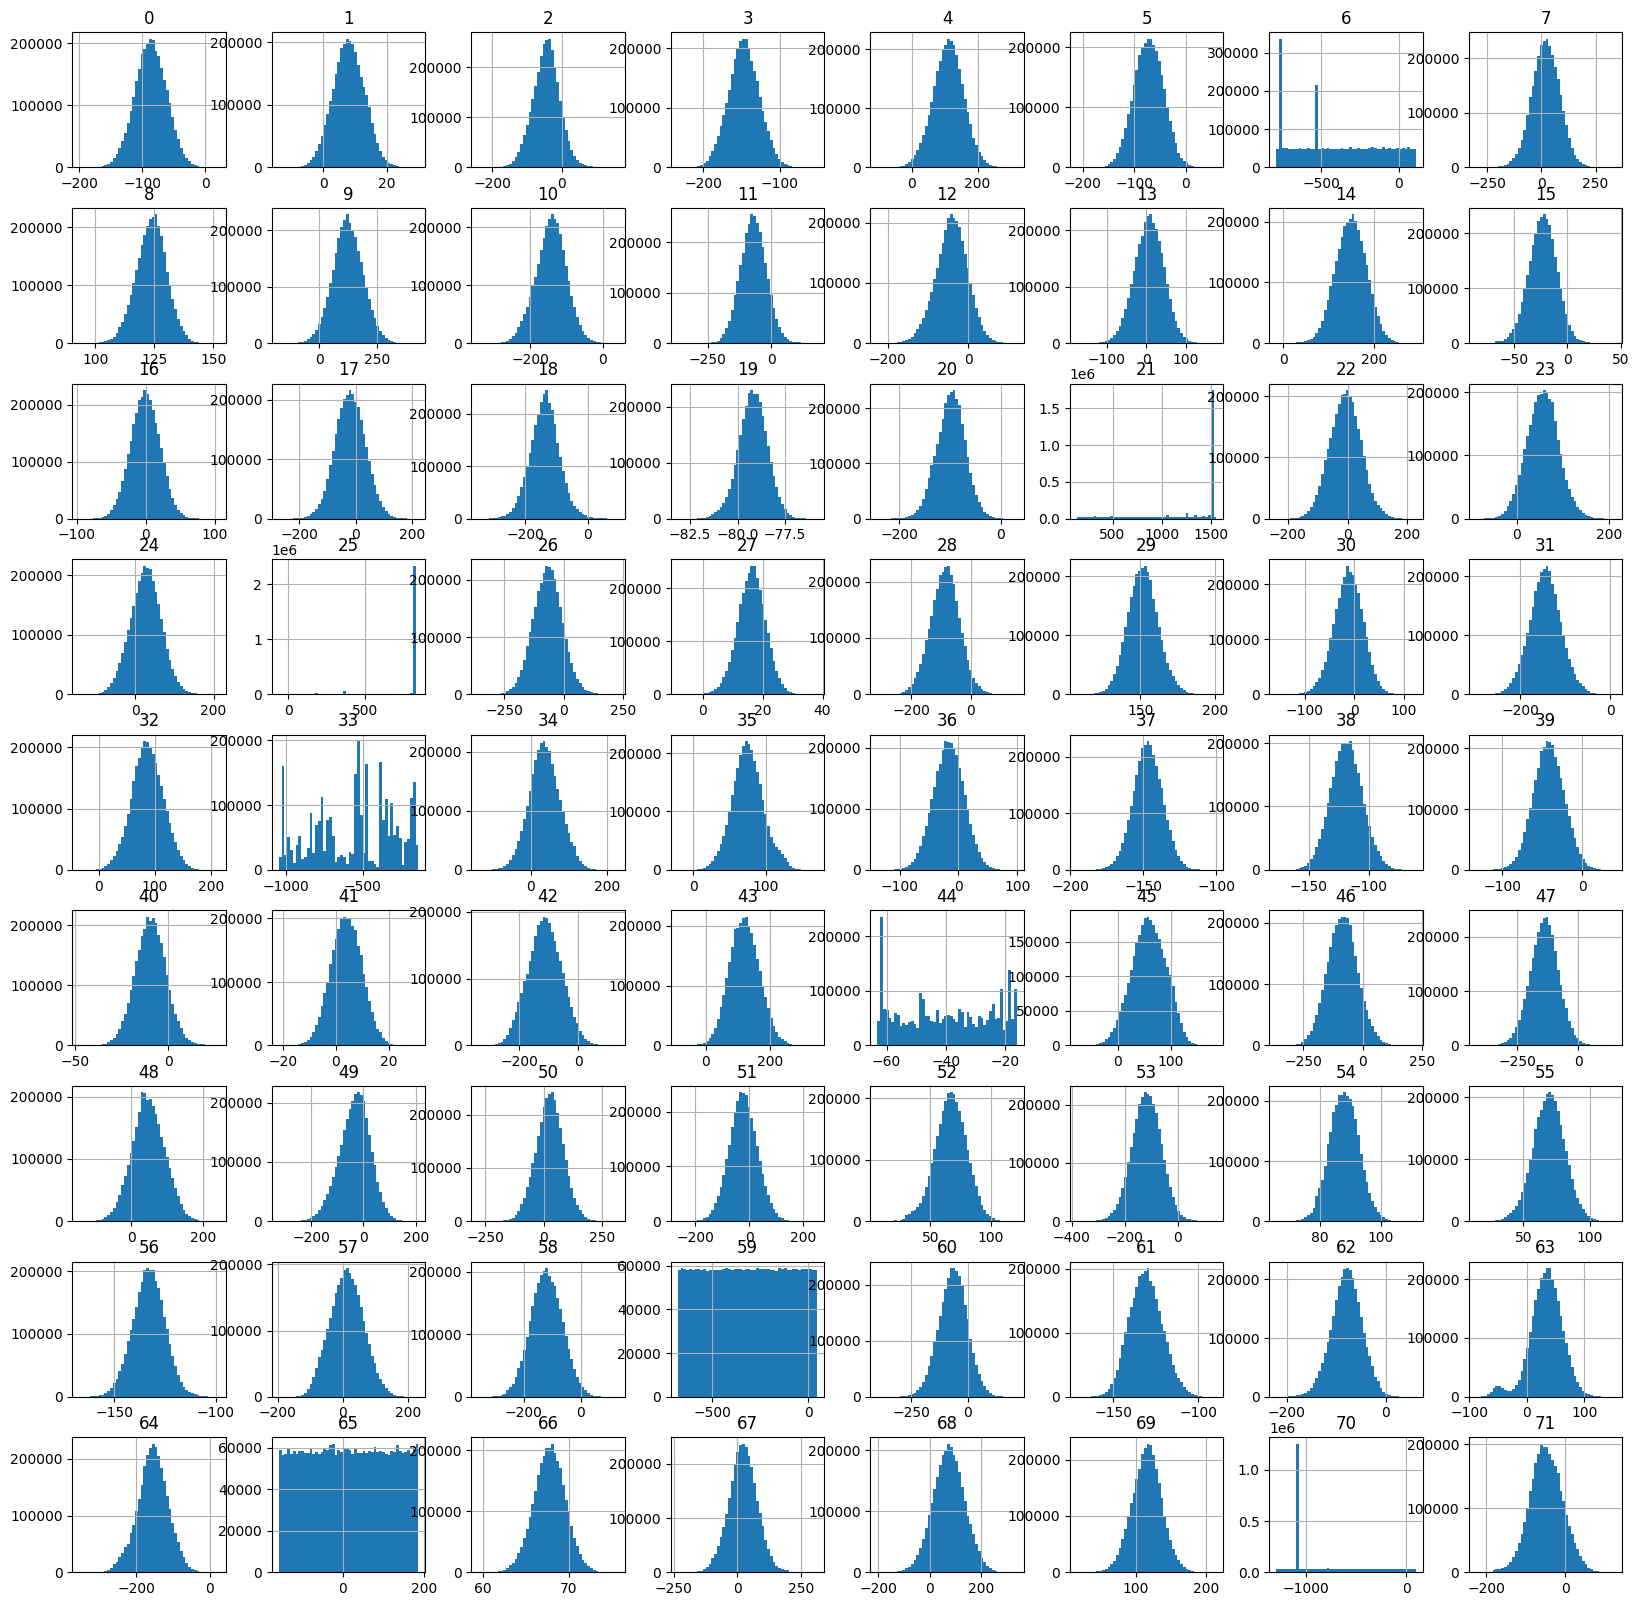

In [15]:
# посмотрим на распределение значений признаков
df_base.hist(figsize=[20, 20], bins=50);

### Вывод

1. Предоставленные данные от Заказчика зашифрованы, смысл данных понять не возможно.
2. Пропусков в данных нет, дубликатов тоже нет
3. Распределение признаков следующие:
- В колонке №6 - есть два образца значения которых более 200 000. У всех остальных данных не более 60 000
- В колонках №21,25,70 - есть одно пиковое значение
- В колонках №33 и 44 - не равномерное распределение и распадается на несколько групп
- В колонках №59, 60 - практически все значения имеют примерно одинаковые данные


## Данные по которым данные оценки экспетов Train dataset

In [16]:
df_train = pd.read_csv("/content/train.csv", index_col=0, dtype=dict_train)
df_train.shape

(100000, 73)

In [17]:
df_train[['0','1','2']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float32
 1   1       100000 non-null  float32
 2   2       100000 non-null  float32
dtypes: float32(3)
memory usage: 1.9+ MB


In [18]:
df_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-85.328667,7.664345,-43.667046,-146.118637,111.770592,-73.178787,-440.615112,21.231590,123.067879,126.120201,...,-81.145546,36.898239,-152.223083,14.001695,67.799553,23.029278,73.412071,115.189728,-709.761536,-48.505699
std,25.803846,4.955651,39.111065,20.434841,47.700958,28.718853,279.017548,65.985214,6.492081,64.912750,...,30.675871,25.357685,41.020287,99.079597,1.838012,55.470760,62.203133,21.582237,405.961060,41.215122
min,-186.280273,-11.560507,-224.896057,-223.307220,-93.272018,-184.962448,-791.469482,-278.582825,94.831146,-142.156952,...,-210.059311,-60.779335,-317.831665,-157.590195,60.668892,-203.746384,-181.973816,22.598862,-1297.871948,-209.935760
25%,-103.309149,4.313784,-69.494486,-160.028522,79.474319,-92.834080,-738.536865,-22.131763,118.674643,82.545027,...,-101.504827,19.774803,-178.929470,-71.745020,66.560656,-14.144571,31.685547,100.589325,-1074.464844,-76.478592
50%,-85.273697,7.652854,-42.830246,-146.067444,112.260101,-73.364422,-511.837753,22.278989,123.087540,125.963341,...,-80.859642,36.711365,-151.576988,14.072662,67.813583,23.441362,72.880192,115.236633,-808.801697,-48.700930
75%,-67.330811,10.981191,-17.713690,-132.277744,143.760826,-53.699613,-201.116577,65.899597,127.541805,169.701004,...,-60.492451,53.919519,-124.436975,100.011024,69.058746,59.941065,114.469225,129.791080,-357.087334,-20.487869
max,14.585236,28.917845,128.108459,-60.751625,301.363586,51.849709,109.625191,288.171844,149.356201,392.827148,...,47.733452,145.667130,11.907364,185.095139,74.779884,266.493317,319.867523,201.761261,98.768234,126.191788


In [19]:
# проверим пропуски в данных
df_train.isna().sum()

0         0
1         0
2         0
3         0
4         0
         ..
68        0
69        0
70        0
71        0
Target    0
Length: 73, dtype: int64

In [20]:
# проверим на дубликаты
df_train.duplicated().sum()

0

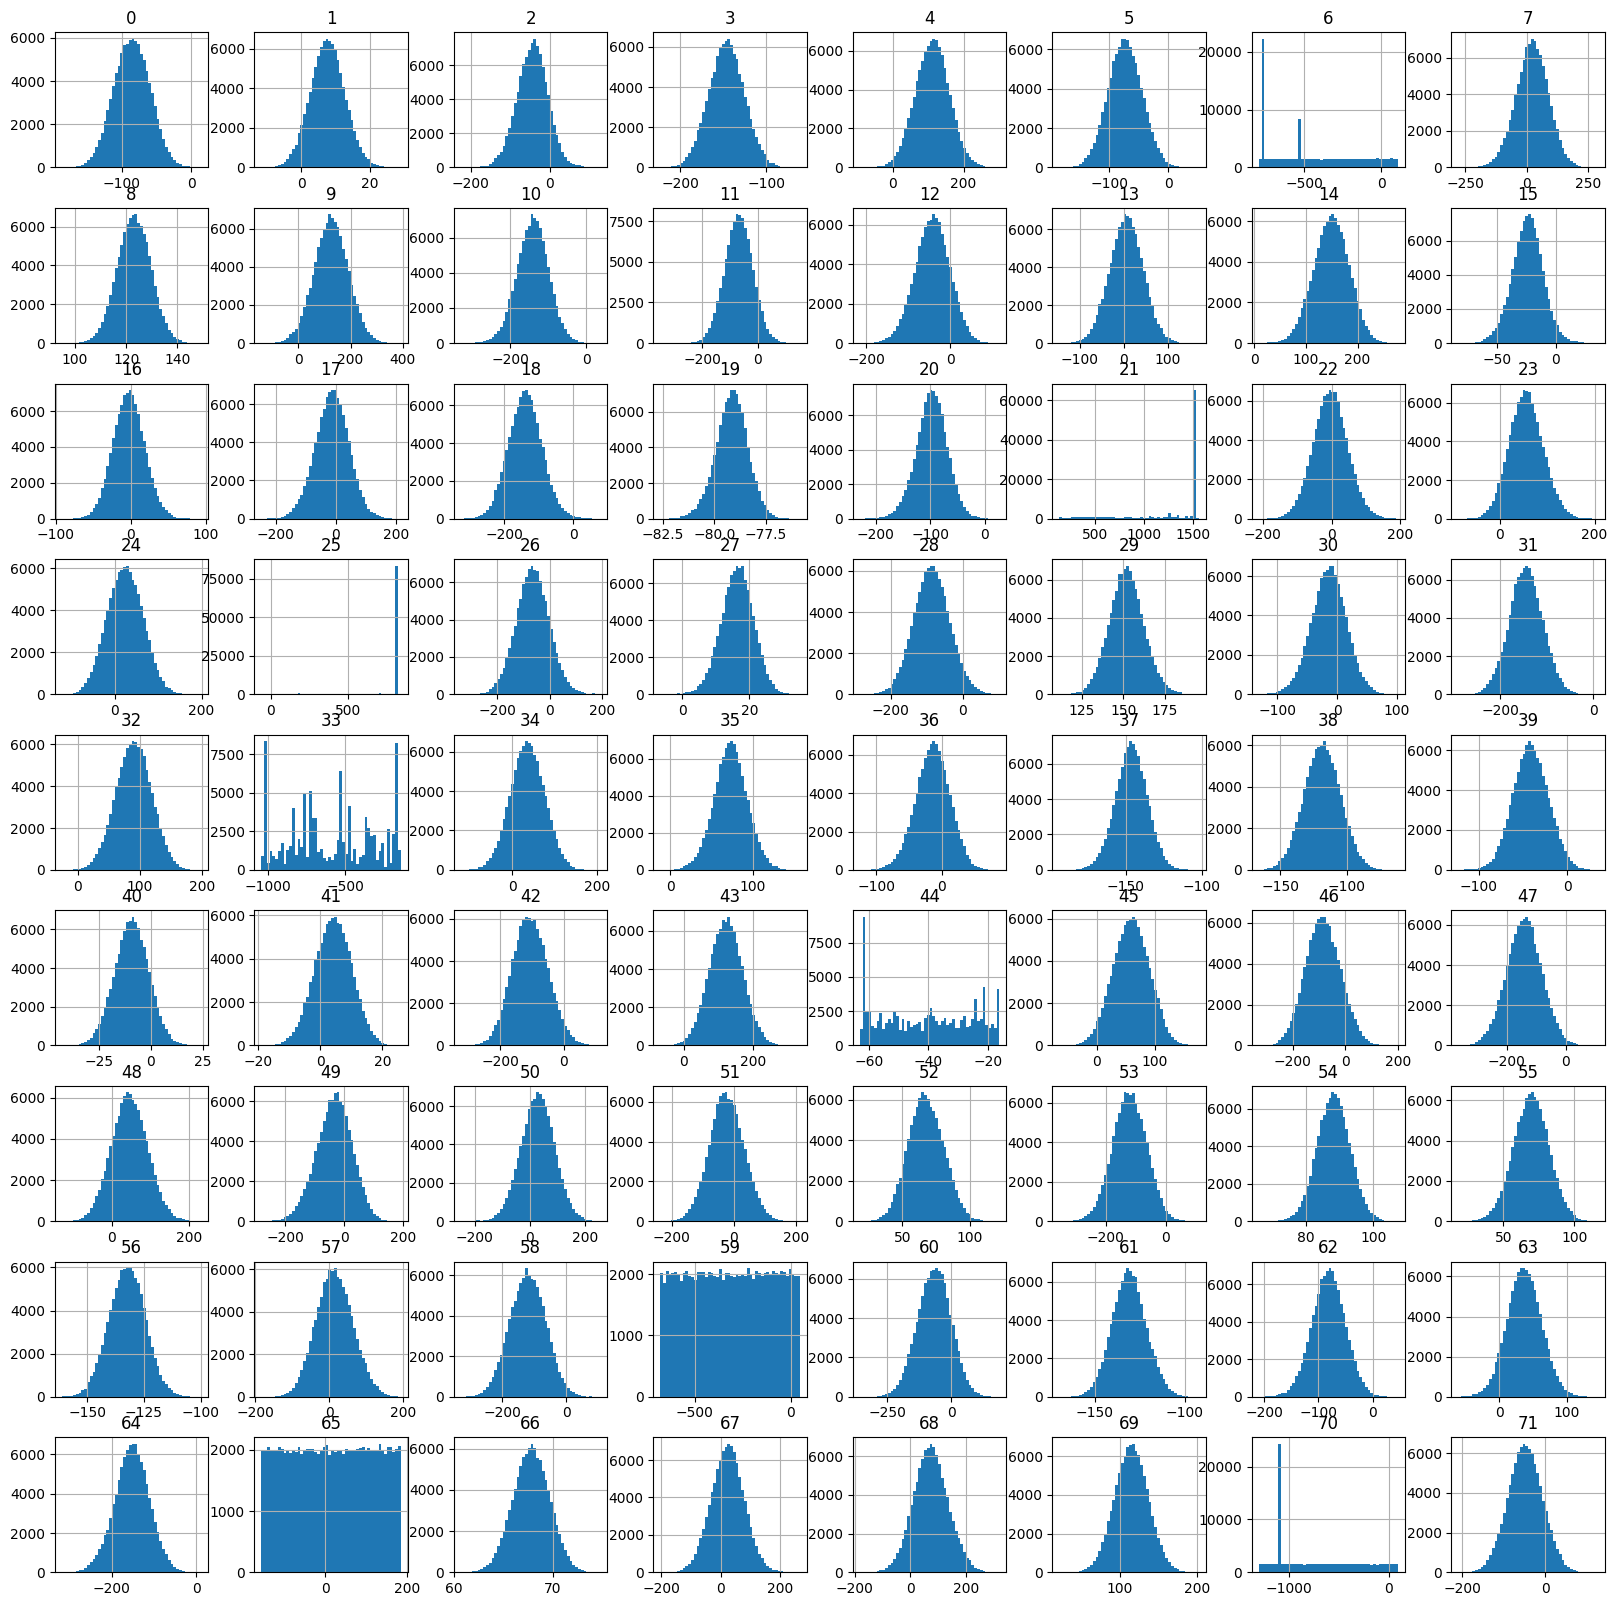

In [21]:
# посмотрим на распределение данных
df_train.hist(figsize=[20, 20], bins=50);

Распределение аналогичное как и в df_base.

## Данные для проверки качества модели

In [22]:
# закачаем данные
df_validation  = pd.read_csv("/content/validation.csv", index_col=0, dtype=dict_train)
df_validation .shape

(100000, 72)

In [23]:
validation_answer = pd.read_csv("/content/validation_answer.csv", index_col=0, dtype=dict_train)
validation_answer.shape

(100000, 1)

In [24]:
df_validation[['0','1','2']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float32
 1   1       100000 non-null  float32
 2   2       100000 non-null  float32
dtypes: float32(3)
memory usage: 1.9+ MB


In [25]:
df_validation.isna().sum()

0     0
1     0
2     0
3     0
4     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 72, dtype: int64

In [26]:
df_validation.duplicated().sum()

0

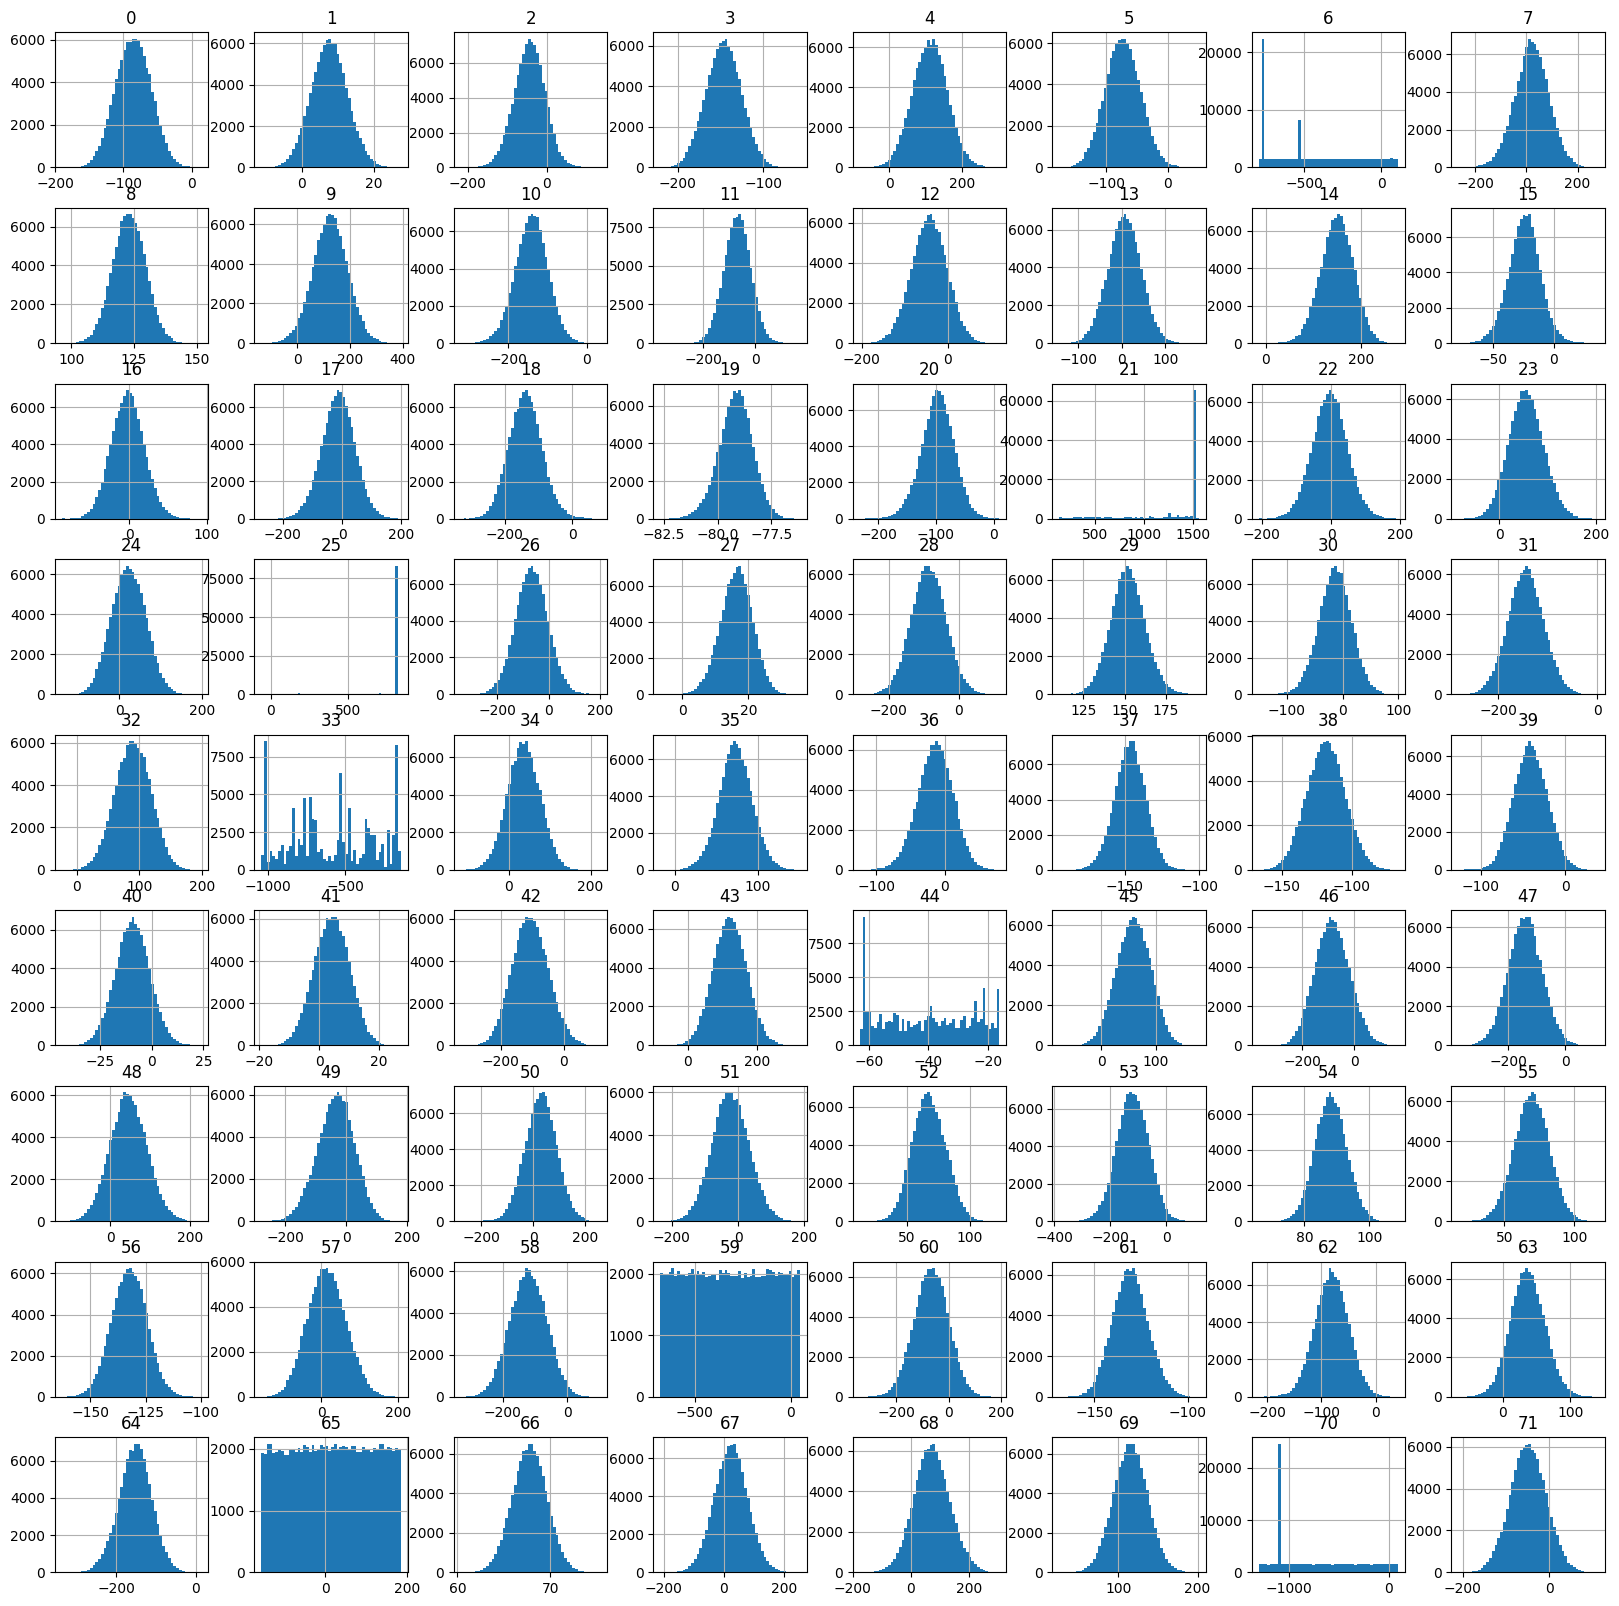

In [27]:
df_validation.hist(figsize=[20, 20], bins=50);

распределение данных обычное как и в основном и тренеровочном дата сете

# Общий вывод

1. Нам даны 3 000 000 данных по товарам на основании которых мы должны подобрать похожие товары для клиента
2. есть дата сет с 100 000 данными ответов экспертов
3. 100 000 запросов с похожими товарами
Все три набора данных обезличены у каждого набора данных есть 72 различных признака. Пропусков и дубликатов по всем наборам данных не обнаружено.

Характер распределений равномерный, есть некоторые отклонения по столбцам:

- В колонке №6 - есть два образца значения которых более 200 000. У всех остальных данных не более 60 000
- В колонках №21,25,70 - есть одно пиковое значение
- В колонках №33 и 44 - не равномерное распределение и распадается на несколько групп
- В колонках №59, 60 - практически все значения имеют примерно одинаковые данные

## Первая модель

In [28]:
dims = df_base.shape[1]
# n_cells = 333
# how many cells
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [29]:
idx_l2.train(np.ascontiguousarray(df_base.values[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))

In [30]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}
#del df_base

Оценки экспертов содержатся в отдельном столбце target. Выделим его в отдельную переменную для последующей передачи модели.

In [31]:
targets = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)

In [32]:
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train.values).astype('float32'), k)

acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

5.898


расчетные данные всего 5,898

## Вторая модель используем Нормализацию данных RobustScaler()

In [33]:
scaler = RobustScaler()
df_base2 = scaler.fit_transform(df_base)
df_train2 = scaler.transform(df_train)

dims = df_base2.shape[1]
# n_cells = 10
# how many cells
quantizer2 = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer2, dims, n_cells)


In [34]:
idx_l2.train(np.ascontiguousarray(df_base2[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base2).astype('float32'))


In [35]:
base_index2 = {k: v for k, v in enumerate(df_base.index.to_list())}

In [36]:
vecs2, idx2 = idx_l2.search(np.ascontiguousarray(df_train2).astype('float32'), k)

acc = 0
for target, el in zip(targets.values.tolist(), idx2.tolist()):
    acc += int(target in [base_index2[r] for r in el])

print(100 * acc / len(idx2))

51.984


В 9 раз улучшились данные

## Третья модель с использованием рангового преобразования для нормализации данных

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [38]:
# Ранговое преобразование
def rank_transform(X):
    X_rank = X.rank()
    X_min = X_rank.min()
    X_max = X_rank.max()
    X_norm = (X_rank - X_min) / (X_max - X_min)
    return X_norm

In [39]:
# Создание функции-трансформера для рангового преобразования
rank_transformer = FunctionTransformer(rank_transform)

In [40]:
# Создание пайплайна
pipeline = Pipeline([
    # Применение рангового преобразования к числовым признакам
    ('numeric_transformer', ColumnTransformer(
        transformers=[
            ('num', rank_transformer, list(df_base.select_dtypes(include=['number']).columns))
        ],
        remainder='passthrough'
    )),
    # Стандартизация данных
    ('scaler', RobustScaler())
])

In [41]:
df_base3 = pipeline.fit_transform(df_base)
df_train3 = pipeline.transform(df_train)
quantizer3 = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer3, dims, n_cells)

In [42]:
idx_l2.train(np.ascontiguousarray(df_base3[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base3).astype('float32'))


In [43]:
base_index3 = {k: v for k, v in enumerate(df_base.index.to_list())}

In [44]:
vecs3, idx3 = idx_l2.search(np.ascontiguousarray(df_train3).astype('float32'), k)

acc = 0
for target, el in zip(targets.values.tolist(), idx3.tolist()):
    acc += int(target in [base_index3[r] for r in el])

print(100 * acc / len(idx3))

62.148


В третьей модули улучшились данные в 6,5 раза

## Четвертая модель используем метод StandartScaler()

In [45]:
# Так как формула для расчёта расстояния между точками в пространстве чувствительна к диапазону значений различных характеристик, предварительно нормализуем данные.
#Для этого используем метод AdjustedScaler из библиотеки adjdatatools.
def AdjustedScaler(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, scaler

In [46]:
# Используtv AdjustedScaler() для масштабирования данных
X_scaled, scaler = AdjustedScaler(df_base.values[:50000, :])

In [47]:
quantizer4 = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer4, dims, n_cells)

In [48]:
idx_l2.train(np.ascontiguousarray(X_scaled).astype('float32'))
idx_l2.add(np.ascontiguousarray(AdjustedScaler(df_base.values)[0]).astype('float32'))

In [49]:
base_index4 = {k: v for k, v in enumerate(df_base.index.to_list())}

In [50]:
df_train_scaled = scaler.transform(df_train.values)

In [51]:
df_validation_transform = scaler.transform(df_validation.values)

In [52]:
vecs4, idx4 = idx_l2.search(np.ascontiguousarray(df_train_scaled).astype('float32'), k)
acc = 0
for target, el in zip(targets.values.tolist(), idx4.tolist()):
    acc += int(target in [base_index4[r] for r in el])

print(100 * acc / len(idx4))

61.541


Увеличились показатели в 10 раз

## Пятая модель использование преобразование квантилей

In [53]:
from sklearn.preprocessing import QuantileTransformer

In [54]:
# Преобразование квантилей
def quantiletransform(X):
    transformer = QuantileTransformer()
    Xquantile = transformer.fit_transform(X)
    return Xquantile

In [55]:
# Создание функции-трансформера для преобразования квантилей
quantiletransformer = FunctionTransformer(quantiletransform)

In [56]:
# Создание пайплайна
pipeline2 = Pipeline([
    # Применение преобразования квантилей к числовым признакам
    ('numerictransformer', ColumnTransformer(
        transformers=[
            ('num', quantiletransformer, list(df_base.select_dtypes(include='number').columns))
        ],
        remainder='passthrough'
    )),
    # Стандартизация данных
    ('scaler', RobustScaler())
])

In [57]:
df_base5 = pipeline2.fit_transform(df_base)
df_train5 = pipeline2.transform(df_train)
quantizer5 = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer5, dims, n_cells)

In [58]:
idx_l2.train(np.ascontiguousarray(df_base5[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base5).astype('float32'))

In [59]:
base_index5 = {k: v for k, v in enumerate(df_base.index.to_list())}

In [60]:
vecs5, idx5 = idx_l2.search(np.ascontiguousarray(df_train5).astype('float32'), k)

acc = 0
for target, el in zip(targets.values.tolist(), idx5.tolist()):
    acc += int(target in [base_index5[r] for r in el])

print(100 * acc / len(idx5))

62.057


В пятой модели увеличились показания в 6,5 раза

Общий Вывод: мы использоватли несколько методов чтобы найти оптимальное решения для подбора предложения клиенту. Наиболее подходит 4 модель которая показала - 61.541

## Анализ результатов поиска

Соберем в таблицу следующие сведения о 100 кандидатах, предложенных FAISS:
- min – расстояние от самого близкого соседа до вектора запроса
- max – расстояние от сотого соседа до вектора запроса
- distance – расстояние от вектора, рекомендованного экспертами, до вектора запроса (NaN, если среди выдачи FAISS он не числится)
- n_in_a_list – порядковый номер вектора, рекомендованного экспертами, в выдаче FAISS (NaN, если среди выдачи FAISS он не числится)
- middle – расстояние от запроса до середины диапазона расстояний в 100 отобранных FAISS (между самым близким и самым дальним соседями)
- dist_from_midle – расстояние от вектора, рекомендованного экспертами, до середины диапазона выдачи

In [61]:
list_of_analysis = []
for target, el, dist in zip(targets.values.tolist(), idx4.tolist(), vecs4.tolist()):
    row = []
    # индекс верного ответа для данного запроса по версии экспертов
    row.append(target)
    # расстояние от самого близкого соседа до вектора запроса
    row.append(dist[0])

    target_not_found = True
    for r in range(len(el)):
        if target == base_index4[el[r]]:
            # расстояние от вектора, рекомендованного экспертами, до вектора запроса
            row.append(dist[r])
            # порядковый номер вектора, рекомендованного экспертами, в выдаче
            row.append(r)

            target_not_found = False
    if target_not_found:
        row.append(np.nan)
        row.append(np.nan)

    # расстояние от сотого соседа до вектора запроса
    row.append(dist[99])
    list_of_analysis.append(row)

In [62]:
# преобразуем в pandas DataFrame
columns = ['target', 'min', 'distance', 'n_in_a_list', 'max']
df_analysis = pd.DataFrame(list_of_analysis, columns=columns)

In [63]:
# расстояние от запроса до середины диапазона расстояний в 100 отобранных FAISS
df_analysis['middle'] = df_analysis['min'] + (df_analysis['max'] + df_analysis['min']) / 2

In [64]:
# расстояние от вектора, рекомендованного экспертами, до середины диапазона выдачи
df_analysis['dist_from_midle'] = df_analysis['middle'] - df_analysis['distance']

In [65]:
# Посмотрим на результаты анализа.
df_analysis

,target,min,distance,n_in_a_list,max,middle,dist_from_midle
0,675816-base,19.182110,19.229383,1.0,36.742702,47.144516,27.915133
1,366656-base,31.056339,NaN,NaN,77.475281,85.322149,NaN
2,1447819-base,18.980476,27.846273,7.0,40.018929,48.480179,20.633905
3,1472602-base,17.237309,17.237309,0.0,68.723671,60.217798,42.980490
4,717819-base,1.780889,5.426029,1.0,11.988298,8.665482,3.239453
...,...,...,...,...,...,...,...
99995,811868-base,13.155098,NaN,NaN,61.126961,50.296127,NaN
99996,1460772-base,19.463089,NaN,NaN,71.288574,64.838921,NaN
99997,2366140-base,5.364414,5.364414,0.0,56.027126,36.060184,30.695770
99998,9252-base,3.118165,NaN,NaN,8.120681,8.737587,NaN


In [66]:
# Выведем сводную таблицу статистических характеристик
df_analysis.describe()

,min,distance,n_in_a_list,max,middle,dist_from_midle
count,100000.000000,61541.000000,61541.000000,100000.000000,100000.000000,61541.000000
mean,16.977159,13.518173,3.709088,56.966333,53.948905,31.062333
std,15.563075,12.578180,12.280332,19.437111,28.169101,11.974960
min,0.025678,0.032510,0.000000,0.214737,0.149017,-34.793575
25%,5.010025,3.436900,0.000000,44.001360,35.204849,24.141876
50%,12.503670,9.854516,0.000000,58.438526,46.734876,32.371448
75%,24.327604,20.440941,1.000000,71.758604,66.922527,39.285926
max,90.249664,87.255249,99.000000,118.983276,190.850395,78.214073


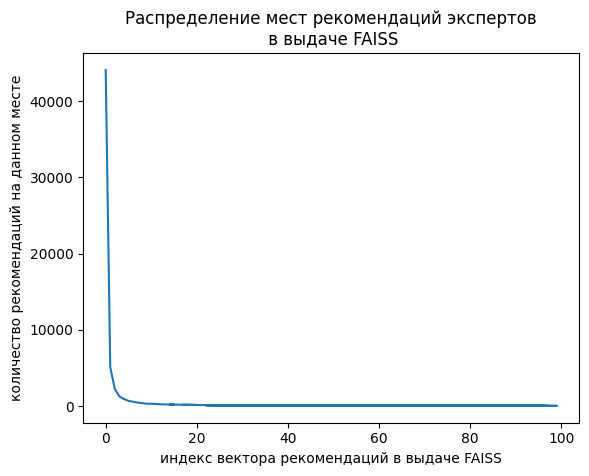

In [67]:
chart = df_analysis['n_in_a_list'].value_counts().plot()
chart.set_title('Распределение мест рекомендаций экспертов\n в выдаче FAISS')
chart.set_xlabel('индекс вектора рекомендаций в выдаче FAISS')
chart.set_ylabel('количество рекомендаций на данном месте')
chart;

## Вывод
Ответы экспертов в выдаче FAISS в 75 % случаев находятся **на местах с 1 по 5**.

**Нет фиксированного расстояния** ни от вектора запроса, ни от середины диапазона рекомендаций, которое можно было бы использовать для более точного поиска средствами FAISS.

Следовательно, **имеет смысл обучить модель** отбирать из рекомендаций FAISS те, которые вероятнее всего похожие на рекомендации экспертов.

# Обучение модели

 в качестве модели, которая отбирает 5 наиболее вероятных кандидатов будем использовать CatBoostClassifier. Подготовим для него обучающий датасет.

## Подготовка данных для обучения модели

Соберем в таблицу для каждого запроса из тренировочного набора данных по 5 строк, которые будут содержать:
- координаты вектора запроса,
- координаты вектора, рекомендованного FAISS (возьмем первые 5 рекомендаций),
- расстояние между этими векторами.

In [68]:
df_for_cb = pd.DataFrame()

# для каждого запроса из обучающего набора данных
for i in range(df_train_scaled.shape[0]):

    # берем индексы FAISS для первых пяти рекомендаций
    df = pd.DataFrame(idx4[i][:5])

    # берем расстояния от запроса до рекомендаций FAISS
    df = pd.concat([df, pd.DataFrame(vecs4[i][:5])], axis=1)

    df.columns = ['idx', 'distance']

    # индекс вектора-запроса для получения его координат
    df['query_idx'] = str(i) +'-query'

    # индекс вектора рекомендаций экспертов
    df['target_idx'] = targets[i]

    df_for_cb = pd.concat([df_for_cb, df], ignore_index=True)

In [69]:
df_for_cb.head()

,idx,distance,query_idx,target_idx
0,755584,19.182110,0-query,675816-base
1,598613,19.229383,0-query,675816-base
2,336969,20.837690,0-query,675816-base
3,1934845,23.071720,0-query,675816-base
4,1136231,23.249918,0-query,675816-base


In [70]:
# функция для получения индекса рекомендаций в базовом наборе товаров по индексу FAISS
def get_base_idx(row):
    return base_index4[row['idx']]

In [71]:
# по внутреннему индексу FAISS восстанавливаем индекс рекомендованного товара в базовом наборе
df_for_cb['base_idx'] = df_for_cb.apply(get_base_idx, axis=1)
df_for_cb

,idx,distance,query_idx,target_idx,base_idx
0,755584,19.182110,0-query,675816-base,877519-base
1,598613,19.229383,0-query,675816-base,675816-base
2,336969,20.837690,0-query,675816-base,361564-base
3,1934845,23.071720,0-query,675816-base,2725256-base
4,1136231,23.249918,0-query,675816-base,1408780-base
...,...,...,...,...,...
499995,1958647,2.024832,99999-query,2769109-base,2769109-base
499996,1404212,58.185467,99999-query,2769109-base,1819743-base
499997,2433126,59.949974,99999-query,2769109-base,3692000-base
499998,483722,60.960331,99999-query,2769109-base,534314-base


Создаем **целевой признак**:
    
1 если индекс рекомендованного FAISS товара совпадает с индексом товара, выбранного экспертами

0 в противном случае.

In [72]:
df_for_cb['target'] = df_for_cb['target_idx'] == df_for_cb['base_idx']
df_for_cb['target'] = df_for_cb['target'].astype('int')
df_for_cb

,idx,distance,query_idx,target_idx,base_idx,target
0,755584,19.182110,0-query,675816-base,877519-base,0
1,598613,19.229383,0-query,675816-base,675816-base,1
2,336969,20.837690,0-query,675816-base,361564-base,0
3,1934845,23.071720,0-query,675816-base,2725256-base,0
4,1136231,23.249918,0-query,675816-base,1408780-base,0
...,...,...,...,...,...,...
499995,1958647,2.024832,99999-query,2769109-base,2769109-base,1
499996,1404212,58.185467,99999-query,2769109-base,1819743-base,0
499997,2433126,59.949974,99999-query,2769109-base,3692000-base,0
499998,483722,60.960331,99999-query,2769109-base,534314-base,0


In [73]:
# добавляем координаты векторов-запросов
df_for_cb = df_for_cb.merge(df_train, how='inner', left_on='query_idx', right_index=True)
df_for_cb

,idx,distance,query_idx,target_idx,base_idx,target,0,1,2,3,...,62,63,64,65,66,67,68,69,70,71
0,755584,19.182110,0-query,675816-base,877519-base,0,-53.882748,17.971436,-42.117104,-183.936676,...,-105.427818,70.107361,-155.802567,-101.965942,65.903793,34.457500,62.642094,134.763596,-415.750244,-25.958572
1,598613,19.229383,0-query,675816-base,675816-base,1,-53.882748,17.971436,-42.117104,-183.936676,...,-105.427818,70.107361,-155.802567,-101.965942,65.903793,34.457500,62.642094,134.763596,-415.750244,-25.958572
2,336969,20.837690,0-query,675816-base,361564-base,0,-53.882748,17.971436,-42.117104,-183.936676,...,-105.427818,70.107361,-155.802567,-101.965942,65.903793,34.457500,62.642094,134.763596,-415.750244,-25.958572
3,1934845,23.071720,0-query,675816-base,2725256-base,0,-53.882748,17.971436,-42.117104,-183.936676,...,-105.427818,70.107361,-155.802567,-101.965942,65.903793,34.457500,62.642094,134.763596,-415.750244,-25.958572
4,1136231,23.249918,0-query,675816-base,1408780-base,0,-53.882748,17.971436,-42.117104,-183.936676,...,-105.427818,70.107361,-155.802567,-101.965942,65.903793,34.457500,62.642094,134.763596,-415.750244,-25.958572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,1958647,2.024832,99999-query,2769109-base,2769109-base,1,-89.048462,10.938594,-53.206207,-144.188583,...,-81.335533,5.184549,-134.788452,-78.863724,66.884628,45.619125,129.991241,100.656708,-43.558285,-80.152908
499996,1404212,58.185467,99999-query,2769109-base,1819743-base,0,-89.048462,10.938594,-53.206207,-144.188583,...,-81.335533,5.184549,-134.788452,-78.863724,66.884628,45.619125,129.991241,100.656708,-43.558285,-80.152908
499997,2433126,59.949974,99999-query,2769109-base,3692000-base,0,-89.048462,10.938594,-53.206207,-144.188583,...,-81.335533,5.184549,-134.788452,-78.863724,66.884628,45.619125,129.991241,100.656708,-43.558285,-80.152908
499998,483722,60.960331,99999-query,2769109-base,534314-base,0,-89.048462,10.938594,-53.206207,-144.188583,...,-81.335533,5.184549,-134.788452,-78.863724,66.884628,45.619125,129.991241,100.656708,-43.558285,-80.152908


Вместо индексов товаров мы будем использовать из координаты. Добавим их к нашим данным.

In [74]:
# добавляем координаты векторов-запросов
df_for_cb = df_for_cb.merge(df_train, how='inner', left_on='query_idx', right_index=True)
df_for_cb

,idx,distance,query_idx,target_idx,base_idx,target,0_x,1_x,2_x,3_x,...,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y
0,755584,19.182110,0-query,675816-base,877519-base,0,-53.882748,17.971436,-42.117104,-183.936676,...,-105.427818,70.107361,-155.802567,-101.965942,65.903793,34.457500,62.642094,134.763596,-415.750244,-25.958572
1,598613,19.229383,0-query,675816-base,675816-base,1,-53.882748,17.971436,-42.117104,-183.936676,...,-105.427818,70.107361,-155.802567,-101.965942,65.903793,34.457500,62.642094,134.763596,-415.750244,-25.958572
2,336969,20.837690,0-query,675816-base,361564-base,0,-53.882748,17.971436,-42.117104,-183.936676,...,-105.427818,70.107361,-155.802567,-101.965942,65.903793,34.457500,62.642094,134.763596,-415.750244,-25.958572
3,1934845,23.071720,0-query,675816-base,2725256-base,0,-53.882748,17.971436,-42.117104,-183.936676,...,-105.427818,70.107361,-155.802567,-101.965942,65.903793,34.457500,62.642094,134.763596,-415.750244,-25.958572
4,1136231,23.249918,0-query,675816-base,1408780-base,0,-53.882748,17.971436,-42.117104,-183.936676,...,-105.427818,70.107361,-155.802567,-101.965942,65.903793,34.457500,62.642094,134.763596,-415.750244,-25.958572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,1958647,2.024832,99999-query,2769109-base,2769109-base,1,-89.048462,10.938594,-53.206207,-144.188583,...,-81.335533,5.184549,-134.788452,-78.863724,66.884628,45.619125,129.991241,100.656708,-43.558285,-80.152908
499996,1404212,58.185467,99999-query,2769109-base,1819743-base,0,-89.048462,10.938594,-53.206207,-144.188583,...,-81.335533,5.184549,-134.788452,-78.863724,66.884628,45.619125,129.991241,100.656708,-43.558285,-80.152908
499997,2433126,59.949974,99999-query,2769109-base,3692000-base,0,-89.048462,10.938594,-53.206207,-144.188583,...,-81.335533,5.184549,-134.788452,-78.863724,66.884628,45.619125,129.991241,100.656708,-43.558285,-80.152908
499998,483722,60.960331,99999-query,2769109-base,534314-base,0,-89.048462,10.938594,-53.206207,-144.188583,...,-81.335533,5.184549,-134.788452,-78.863724,66.884628,45.619125,129.991241,100.656708,-43.558285,-80.152908


In [75]:
# добавляем координаты векторов-рекомендаций FAISS
df_for_cb = df_for_cb.merge(df_base, how='inner', left_on='base_idx', right_index=True)

In [76]:
df_for_cb

,idx,distance,query_idx,target_idx,base_idx,target,0_x,1_x,2_x,3_x,...,62,63,64,65,66,67,68,69,70,71
0,755584,19.182110,0-query,675816-base,877519-base,0,-53.882748,17.971436,-42.117104,-183.936676,...,-99.612366,79.956398,-164.981705,-25.864149,65.697540,46.384483,51.909309,130.986984,-589.315308,-36.495922
83735,755584,19.011257,16747-query,279936-base,877519-base,0,-75.546265,14.592499,-64.426750,-170.850128,...,-99.612366,79.956398,-164.981705,-25.864149,65.697540,46.384483,51.909309,130.986984,-589.315308,-36.495922
144539,755584,29.707369,28907-query,674092-base,877519-base,0,-73.177963,19.489805,-31.667213,-180.049789,...,-99.612366,79.956398,-164.981705,-25.864149,65.697540,46.384483,51.909309,130.986984,-589.315308,-36.495922
346969,755584,27.401516,69393-query,488769-base,877519-base,0,-99.104042,18.745882,-86.029541,-193.694870,...,-99.612366,79.956398,-164.981705,-25.864149,65.697540,46.384483,51.909309,130.986984,-589.315308,-36.495922
449538,755584,28.483194,89907-query,2073267-base,877519-base,0,-77.668312,18.383730,-75.897972,-168.938232,...,-99.612366,79.956398,-164.981705,-25.864149,65.697540,46.384483,51.909309,130.986984,-589.315308,-36.495922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499992,2078497,4.220054,99998-query,9252-base,2991529-base,0,-77.321770,10.120371,-63.995037,-115.817314,...,-186.923035,68.258987,-175.900391,-90.671989,65.499023,-35.049820,59.731182,112.219269,-1074.464844,-75.903534
499993,448293,5.389267,99998-query,9252-base,491760-base,0,-77.321770,10.120371,-63.995037,-115.817314,...,-186.923035,68.258987,-175.900391,-90.671989,65.499023,-35.049820,59.731182,112.219269,-1074.464844,-75.903534
499994,2787126,5.568146,99998-query,9252-base,4449762-base,0,-77.321770,10.120371,-63.995037,-115.817314,...,-178.746887,67.276917,-168.337082,-100.841591,65.536568,-13.858017,57.408264,110.485840,-1074.464844,-68.031181
499995,1958647,2.024832,99999-query,2769109-base,2769109-base,1,-89.048462,10.938594,-53.206207,-144.188583,...,-81.340462,5.186640,-134.781296,-78.863724,66.884613,45.607502,129.992447,100.652786,-43.558285,-80.150963


В качестве характеристик для обучения будем брать только расстояния между запросами и рекомендациями, а также координаты векторов. Остальные столбцы носят вспомогательный характер, удалим их.

In [77]:
# характеристики для обучения
cb_features = df_for_cb.drop(['idx', 'query_idx', 'target_idx', 'base_idx', 'target'], axis=1)
cb_features

,distance,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,...,62,63,64,65,66,67,68,69,70,71
0,19.182110,-53.882748,17.971436,-42.117104,-183.936676,187.517487,-87.144928,-347.360596,38.307602,109.085564,...,-99.612366,79.956398,-164.981705,-25.864149,65.697540,46.384483,51.909309,130.986984,-589.315308,-36.495922
83735,19.011257,-75.546265,14.592499,-64.426750,-170.850128,193.775101,-70.640450,-79.199203,58.431396,110.908203,...,-99.612366,79.956398,-164.981705,-25.864149,65.697540,46.384483,51.909309,130.986984,-589.315308,-36.495922
144539,29.707369,-73.177963,19.489805,-31.667213,-180.049789,190.049408,-91.312149,-773.892639,13.572502,111.856895,...,-99.612366,79.956398,-164.981705,-25.864149,65.697540,46.384483,51.909309,130.986984,-589.315308,-36.495922
346969,27.401516,-99.104042,18.745882,-86.029541,-193.694870,194.661362,-85.322052,-43.156532,23.993803,113.011009,...,-99.612366,79.956398,-164.981705,-25.864149,65.697540,46.384483,51.909309,130.986984,-589.315308,-36.495922
449538,28.483194,-77.668312,18.383730,-75.897972,-168.938232,171.727081,-64.193642,99.828613,57.031982,116.810745,...,-99.612366,79.956398,-164.981705,-25.864149,65.697540,46.384483,51.909309,130.986984,-589.315308,-36.495922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499992,4.220054,-77.321770,10.120371,-63.995037,-115.817314,140.170425,-94.855591,-676.686829,125.189285,117.982079,...,-186.923035,68.258987,-175.900391,-90.671989,65.499023,-35.049820,59.731182,112.219269,-1074.464844,-75.903534
499993,5.389267,-77.321770,10.120371,-63.995037,-115.817314,140.170425,-94.855591,-676.686829,125.189285,117.982079,...,-186.923035,68.258987,-175.900391,-90.671989,65.499023,-35.049820,59.731182,112.219269,-1074.464844,-75.903534
499994,5.568146,-77.321770,10.120371,-63.995037,-115.817314,140.170425,-94.855591,-676.686829,125.189285,117.982079,...,-178.746887,67.276917,-168.337082,-100.841591,65.536568,-13.858017,57.408264,110.485840,-1074.464844,-68.031181
499995,2.024832,-89.048462,10.938594,-53.206207,-144.188583,143.445328,-86.684189,-79.986290,77.225540,117.949432,...,-81.340462,5.186640,-134.781296,-78.863724,66.884613,45.607502,129.992447,100.652786,-43.558285,-80.150963


In [78]:
# целевой признак
cb_target = df_for_cb['target']
cb_target.value_counts() / cb_target.shape[0]

0    0.89281
1    0.10719
Name: target, dtype: float64

In [79]:
class_frequency = cb_target.value_counts()
class_frequency

0    446405
1     53595
Name: target, dtype: int64

Видим, что в целевом признаке очень сильный дисбаланс классов. Исправим это с помощью методики downsampling.

Видим, что в целевом признаке очень сильный дисбаланс классов. Исправим это с помощью методики downsampling.

In [80]:
def downsample(features, target, fraction, RandomState):
    # создаем вспомогательные переменные для каждого класса
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    # уменьшаем с помощью sample число объектов более частого класса
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=RandomState)] + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=RandomState)] + [target_ones])

    # перемешиваем выборки
    features_downsampled = shuffle(
        features_downsampled,
        random_state=RandomState
    )
    target_downsampled = shuffle(
        target_downsampled,
        random_state=RandomState
    )

    return features_downsampled, target_downsampled

In [81]:
#from sklearn.preprocessing import StandardScaler
#from catboost import CatBoostClassifier

In [82]:
#def scalefeatures(features):
#    scaler = StandardScaler()
#   scaledfeatures = scaler.fit_transform(features)
#    return scaledfeatures

In [83]:
# Применяем ScalerFaissCatboost вместо downsample
def ScalerFaissCatboost(X, y):
    # Шкалируем признаки
    scaledX = scalefeatures(X)

    # Определяем размерность векторов
    d = scaledX.shape1

    # Создаем индекс
    index = faiss.IndexFlatL2(d)

    # Добавляем векторы в индекс
    index.add(scaledX.astype(np.float32))

    # Выполняем поиск ближайших соседей
    labelsI = index.search(scaledX.astype(np.float32), 2)

    # Проверяем, что самые близкие соседи являются соседями одного класса
    labels = y.values.reshape(-1, 1)
    isneighborsamelabel = (labelsI[:, 0] == labelsI[:, 1]).flatten()

    # Выбираем только объекты, у которых оба соседа принадлежат к одному классу
    Xfaiss = scaledXis_neighbor_same_label
    yfaiss = y[isneighborsamelabel]

    return Xfaiss, yfaiss

In [84]:
#features_downsampled, target_downsampled = ScalerFaissCatboost(cb_features, cb_target)

In [85]:
features_downsampled, target_downsampled = downsample(
    cb_features,
    cb_target,
    class_frequency[1]/class_frequency[0],
    123456
)

In [86]:
# контроль баланса классов
target_downsampled.value_counts()

0    53595
1    53595
Name: target, dtype: int64

In [87]:
# инициализируем модель
cbc = CatBoostClassifier(auto_class_weights = 'Balanced', verbose=50)

In [88]:
# обучаем модель
cbc.fit(features_downsampled, target_downsampled)

Learning rate set to 0.075825
0:	learn: 0.6446795	total: 193ms	remaining: 3m 12s
50:	learn: 0.3226693	total: 5.2s	remaining: 1m 36s
100:	learn: 0.2744463	total: 11s	remaining: 1m 38s
150:	learn: 0.2456085	total: 16s	remaining: 1m 29s
200:	learn: 0.2240725	total: 21s	remaining: 1m 23s
250:	learn: 0.2113577	total: 26.7s	remaining: 1m 19s
300:	learn: 0.2023184	total: 31.5s	remaining: 1m 13s
350:	learn: 0.1932765	total: 37.3s	remaining: 1m 8s
400:	learn: 0.1868559	total: 41.8s	remaining: 1m 2s
450:	learn: 0.1802005	total: 47.4s	remaining: 57.7s
500:	learn: 0.1750260	total: 51.9s	remaining: 51.7s
550:	learn: 0.1703283	total: 56.4s	remaining: 46s
600:	learn: 0.1660143	total: 1m 1s	remaining: 41.1s
650:	learn: 0.1615062	total: 1m 6s	remaining: 35.6s
700:	learn: 0.1572263	total: 1m 11s	remaining: 30.6s
750:	learn: 0.1539591	total: 1m 16s	remaining: 25.3s
800:	learn: 0.1498747	total: 1m 20s	remaining: 20.1s
850:	learn: 0.1466458	total: 1m 26s	remaining: 15.1s
900:	learn: 0.1439713	total: 1m 30s

# Проверка на валидационной выборке

In [89]:
#df_validation_transform
val_vecs, val_idx = idx_l2.search(np.ascontiguousarray(df_validation_transform).astype('float32'), 100)

In [90]:
validation_answer = pd.read_csv("/content/validation_answer.csv", index_col=0, dtype=dict_train)
validation_answer.head()

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


In [91]:
# accuracy@1100
acc = 0
for target, el in zip(validation_answer.values.tolist(), val_idx.tolist()):
    acc += int(target[0] in [base_index4[r] for r in el])

print(100* acc / len(idx))

54.006


# Соберем данные для передачи в CatBoost

In [ ]:
val_df_for_cb = pd.DataFrame()

# for i in range(2):
for i in range(df_validation_transform.shape[0]):
    df = pd.DataFrame(val_idx[i][:10])
    df = pd.concat([df, pd.DataFrame(val_vecs[i][:10])], axis=1)

    df.columns = ['idx', 'distance']
    df['query_idx'] = str(100000+i) +'-query'
    df['target_idx'] = validation_answer.values[i][0]
    val_df_for_cb = pd.concat([val_df_for_cb, df], ignore_index=True)

In [93]:
val_df_for_cb.head()

,idx,distance,query_idx,target_idx
0,2192372,19.913687,100000-query,2676668-base
1,2177660,22.070398,100000-query,2676668-base
2,342838,24.732975,100000-query,2676668-base
3,574649,25.219677,100000-query,2676668-base
4,2504096,25.730427,100000-query,2676668-base


In [94]:
# по внутреннему индексу FAISS восстанавливаем индекс рекомендованного товара в базовом наборе
val_df_for_cb['base_idx'] = val_df_for_cb.apply(get_base_idx, axis=1)
val_df_for_cb.head()

,idx,distance,query_idx,target_idx,base_idx
0,2192372,19.913687,100000-query,2676668-base,3209652-base
1,2177660,22.070398,100000-query,2676668-base,3181043-base
2,342838,24.732975,100000-query,2676668-base,368296-base
3,574649,25.219677,100000-query,2676668-base,645855-base
4,2504096,25.730427,100000-query,2676668-base,3839597-base


In [95]:
# добавляем координаты векторов-запросов
val_df_for_cb = val_df_for_cb.merge(df_validation, how='inner', left_on='query_idx', right_index=True)
val_df_for_cb.head()

,idx,distance,query_idx,target_idx,base_idx,0,1,2,3,4,...,62,63,64,65,66,67,68,69,70,71
0,2192372,19.913687,100000-query,2676668-base,3209652-base,-57.372734,3.597752,-13.213642,-125.926788,110.745941,...,-75.513023,52.830902,-143.439453,59.051933,69.282242,61.927513,111.592529,115.140656,-1099.130493,-117.079361
1,2177660,22.070398,100000-query,2676668-base,3181043-base,-57.372734,3.597752,-13.213642,-125.926788,110.745941,...,-75.513023,52.830902,-143.439453,59.051933,69.282242,61.927513,111.592529,115.140656,-1099.130493,-117.079361
2,342838,24.732975,100000-query,2676668-base,368296-base,-57.372734,3.597752,-13.213642,-125.926788,110.745941,...,-75.513023,52.830902,-143.439453,59.051933,69.282242,61.927513,111.592529,115.140656,-1099.130493,-117.079361
3,574649,25.219677,100000-query,2676668-base,645855-base,-57.372734,3.597752,-13.213642,-125.926788,110.745941,...,-75.513023,52.830902,-143.439453,59.051933,69.282242,61.927513,111.592529,115.140656,-1099.130493,-117.079361
4,2504096,25.730427,100000-query,2676668-base,3839597-base,-57.372734,3.597752,-13.213642,-125.926788,110.745941,...,-75.513023,52.830902,-143.439453,59.051933,69.282242,61.927513,111.592529,115.140656,-1099.130493,-117.079361


In [ ]:
# добавляем координаты векторов-рекомендаций FAISS
val_df_for_cb = val_df_for_cb.merge(df_base, how='inner', left_on='base_idx', right_index=True)
val_df_for_cb.head()

In [ ]:
# характеристики для CatBoost
val_cb_features = val_df_for_cb.drop(['idx', 'query_idx', 'target_idx', 'base_idx'], axis=1)
val_cb_features.head()

С помощью CatBoost для каждого предсказания вычислим вероятность того, что оно совпадает с рекомендациями экспертов.

In [ ]:
predictions = cbc.predict_proba(val_cb_features)

predictions = pd.DataFrame(predictions)
predictions.drop([0], axis=1, inplace=True)
predictions.columns=['predict_proba']
predictions

Для оценки качества модели отберем для каждого запроса по 5 самых вероятных товаров из базового набора, добавим столбец с ожидаемыми ответами к нашим предсказаниям, а затем сравним их с рекомендациями экспертов.

In [ ]:
# добавляем вероятности для предсказаний
val_df_for_cb = val_df_for_cb.merge(
    predictions.loc[:, 'predict_proba'],
    how='inner',
    left_index=True,
    right_index=True
)
val_df_for_cb.head()

In [ ]:
# уберем координаты векторов
recommendations = val_df_for_cb.loc[:, ['query_idx', 'base_idx', 'predict_proba']]
recommendations

In [ ]:
# оставим по 5 рекомендаций для каждого запроса
results = pd.DataFrame()
for query in recommendations['query_idx'].unique():
    results = pd.concat(
        [
            results,
            recommendations[
                recommendations['query_idx'] == query
            ].sort_values(['predict_proba'], ascending=False)[:5]
        ],
        ignore_index=True)

In [ ]:
results.head(10)

In [ ]:
# присоединяем верные ответы
results = results.merge(validation_answer, how='inner', left_on='query_idx', right_index=True)

In [ ]:
# добавим столбец, который показывает,
# совпадает ли рекомендованный вектор с указаниями экспертов
results['accuracy'] = results['base_idx'] == results['Expected']
results['accuracy'] = results['accuracy'].astype('int')

In [ ]:
# вычислим accuracy@5
results['accuracy'].sum() / 100000 * 100

## Общий вывод

<u>Поиск рекомендуемых товаров</u>

Осуществляется в **два шага**.

На первом **отбираются 10** наиболее вероятных кандидатов с помощью библиотеки **FAISS**. **accuracy@10** на этом этапе составляет **58 %**.

На втором этапе с помощью модели машинного обучения **CatBoost из 10 кандидатов для каждого запроса отбирается 5**.

**accuracy@5** модели составляет **29,5 %**

P.S. Если честно я не понимаю как это можно применить в жизни! У меня просто не укладывается в голове. Например, клинет зашел ко мне на сайт время в среднем которое прододит клинет составляет 20-30 секунд, а моя работа пересчитывается час! Пока я ему предскажу что дополнительно нужно смотреть он уйдет 10 раз с моего сайта. Алгоритм должен работать максимум 2-3 секунды, т.к. клиент быстро будет искать на сайте и я должен ориентироваться что он ищет в зависимости от его запросов и нажатий на конпки на сайте. Может я не прав но, думаю что это не жизненная схема. Это только для учебы и для теории не более того. Или нужно обучать нас как то по другому. Чтобы это все считалось быстро, иначе всех нас разгонят "ссанными" трапками